In [1]:
from standardInclude import *

Welcome to JupyROOT 6.12/06
For interactive plots, run: setint()
To return to non-interactive plots (default state), run: noint()


In [2]:
#f = r.TFile("./data/results_10MissingOutputFiles_9day_histOnly.root")
f = r.TFile("./data/results_1MissingFile_FullVsTrunc.root")
f.ls()

TFile**		./data/results_1MissingFile_FullVsTrunc.root	
 TFile*		./data/results_1MissingFile_FullVsTrunc.root	
  KEY: TDirectoryFile	clustersAndCoincidences;1	clustersAndCoincidences (ClusterAndCoincidenceHistograms) folder
  KEY: TDirectoryFile	clustersAndCoincidencesTrunc;1	clustersAndCoincidencesTrunc (ClusterAndCoincidenceHistograms) folder
  KEY: TDirectoryFile	farline;1	farline (CaloFarlineHistograms) folder
  KEY: TDirectoryFile	farlineTrunc;1	farlineTrunc (CaloFarlineHistograms) folder
  KEY: TDirectoryFile	clusterCompare;1	clusterCompare (ReconComparisonTruncatedVsFull) folder


In [3]:
clusters = f.Get("clustersAndCoincidences").Get("clusters").Clone("clusters")

In [4]:
fileString = "_pileupRebinTest"
print("Creating files with:", fileString, "suffix")

Creating files with: _pileupRebinTest suffix


In [5]:
Ninitial = clusters.Project3D("yx").Clone()
Ninitial.Rebin2D(10,10)

<ROOT.TH2D object ("clusters_yx") at 0x7fffc06eec40>

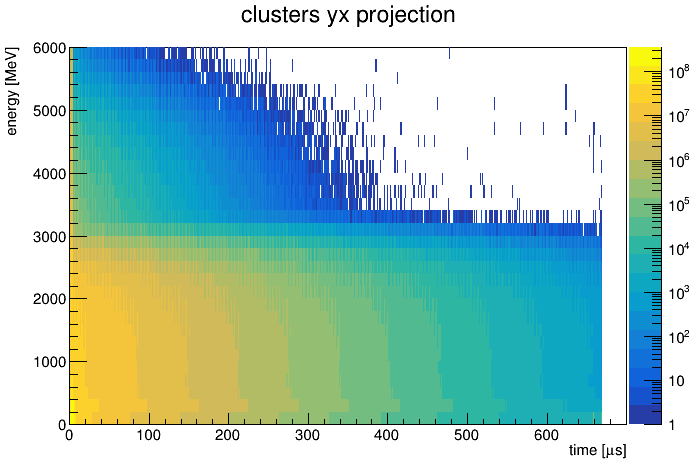

In [6]:
c = r.TCanvas()
Ninitial.Draw("colz")
c.SetLogz()
c.Draw()

---

# Pileup correction

### Lets follow the recipe outlined in Aaron's thesis, Page 175-180

In [7]:
# first define a function which takes a histogram and returns the quantity described in Eqn. 6.12
def rhoDoublePulse( hist, E, t ):
    timeBin = hist.GetXaxis().FindBin( t )
    h2 = hist.ProjectionY("h2", timeBin, timeBin)
    
    Nbins = h2.GetNbinsX() 
    Emin = h2.GetBinCenter(1) - h2.GetBinWidth(1)/2.0
    Emax = h2.GetBinCenter(Nbins) + h2.GetBinWidth(Nbins)/2.0
        
    rho = 0
    for bin in range(Nbins):
        E2 = h2.GetBinCenter(bin)
        if( E < E2 ):
            r1 = 0
        else:
            bin2 = h2.FindBin( E - E2 )
            r1 = h2.GetBinContent(bin2)
            
        r2 = h2.GetBinContent(bin)
        rho += r1*r2
        
    #print("Rho: ", rho)
    
    return rho;

In [8]:
#now build a histogram which has that function evaluated everywhere on the grid of our input histogram
rhoDoubleHist = Ninitial.Clone("rhoDoubleHist")
rhoDoubleHist.Reset()

In [9]:
nBinsX = rhoDoubleHist.GetXaxis().GetNbins()
nBinsY = rhoDoubleHist.GetYaxis().GetNbins()

for binx in range(1,nBinsX+1):
    print(binx,"/",nBinsX+1)
    for biny in range(1,nBinsY+1):
        Ei = rhoDoubleHist.GetYaxis().GetBinCenter(biny)
        ti = rhoDoubleHist.GetXaxis().GetBinCenter(binx)
        rhoi = rhoDoublePulse(Ninitial, Ei, ti)
        #print(rhoi)
        rhoDoubleHist.SetBinContent(binx,biny,rhoi)

1 / 470
2 / 470
3 / 470
4 / 470
5 / 470
6 / 470
7 / 470
8 / 470
9 / 470
10 / 470
11 / 470
12 / 470
13 / 470
14 / 470
15 / 470
16 / 470
17 / 470
18 / 470
19 / 470
20 / 470
21 / 470
22 / 470
23 / 470
24 / 470
25 / 470
26 / 470
27 / 470
28 / 470
29 / 470
30 / 470
31 / 470
32 / 470
33 / 470
34 / 470
35 / 470
36 / 470
37 / 470
38 / 470
39 / 470
40 / 470
41 / 470
42 / 470
43 / 470
44 / 470
45 / 470
46 / 470
47 / 470
48 / 470
49 / 470
50 / 470
51 / 470
52 / 470
53 / 470
54 / 470
55 / 470
56 / 470
57 / 470
58 / 470
59 / 470
60 / 470
61 / 470
62 / 470
63 / 470
64 / 470
65 / 470
66 / 470
67 / 470
68 / 470
69 / 470
70 / 470
71 / 470
72 / 470
73 / 470
74 / 470
75 / 470
76 / 470
77 / 470
78 / 470
79 / 470
80 / 470
81 / 470
82 / 470
83 / 470
84 / 470
85 / 470
86 / 470
87 / 470
88 / 470
89 / 470
90 / 470
91 / 470
92 / 470
93 / 470
94 / 470
95 / 470
96 / 470
97 / 470
98 / 470
99 / 470
100 / 470
101 / 470
102 / 470
103 / 470
104 / 470
105 / 470
106 / 470
107 / 470
108 / 470
109 / 470
110 / 470
111 / 47

In [10]:
c.Print("./pileupCorrection/rhoDoubleHist"+fileString+".root")

Info in <TCanvas::SaveAs>: ROOT file ./pileupCorrection/rhoDoubleHist_pileupRebinTest.root has been created


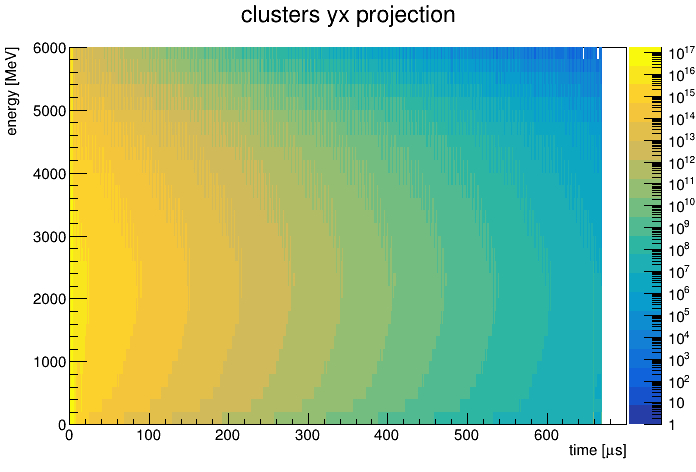

In [11]:
c = r.TCanvas()
rhoDoubleHist.Draw("colz")
c.SetLogz()
c.Draw()

### Now lets create a histogram built form equation 6.13 using the 6.12 histogram

In [12]:
doublePileup = Ninitial.Clone("doublePileup")
doublePileup.Reset()

In [13]:
deltaT = 2

In [14]:
def rhoDoublePileup(E, t, rhoDoubleHist, Ninitial, deltaT):
    histBinEtDouble = rhoDoubleHist.FindBin(t,E)
    histBinEtN = Ninitial.FindBin(t,E)
    histBintN = Ninitial.GetXaxis().FindBin(t)
    histBinEN = Ninitial.GetYaxis().FindBin(E)
    hi = Ninitial.ProjectionY("", histBintN, histBintN).Clone()
    integralN = hi.Integral(hi.FindBin(histBinEN),-1)
    rho = deltaT * ( rhoDoubleHist.GetBinContent(histBinEtDouble) - 2*Ninitial.GetBinContent(histBinEtN)*integralN )
    
    return rho

In [15]:
nBinsX = doublePileup.GetXaxis().GetNbins()
nBinsY = doublePileup.GetYaxis().GetNbins()

for binx in range(1,nBinsX+1):
    #if binx > 100:
    #    break
    print(binx,"/",nBinsX+1)
    for biny in range(1,nBinsY+1):
        Ei = doublePileup.GetYaxis().GetBinCenter(biny)
        ti = doublePileup.GetXaxis().GetBinCenter(binx)
        rhoi = rhoDoublePileup(Ei, ti, rhoDoubleHist, Ninitial, deltaT)
        #print(rhoi)
        doublePileup.SetBinContent(binx,biny,rhoi)

1 / 470
2 / 470
3 / 470
4 / 470
5 / 470
6 / 470
7 / 470
8 / 470
9 / 470
10 / 470
11 / 470
12 / 470
13 / 470
14 / 470
15 / 470
16 / 470
17 / 470
18 / 470
19 / 470
20 / 470
21 / 470
22 / 470
23 / 470
24 / 470
25 / 470
26 / 470
27 / 470
28 / 470
29 / 470
30 / 470
31 / 470
32 / 470
33 / 470
34 / 470
35 / 470
36 / 470
37 / 470
38 / 470
39 / 470
40 / 470
41 / 470
42 / 470
43 / 470
44 / 470
45 / 470
46 / 470
47 / 470
48 / 470
49 / 470
50 / 470
51 / 470
52 / 470
53 / 470
54 / 470
55 / 470
56 / 470
57 / 470
58 / 470
59 / 470
60 / 470
61 / 470
62 / 470
63 / 470
64 / 470
65 / 470
66 / 470
67 / 470
68 / 470
69 / 470
70 / 470
71 / 470
72 / 470
73 / 470
74 / 470
75 / 470
76 / 470
77 / 470
78 / 470
79 / 470
80 / 470
81 / 470
82 / 470
83 / 470
84 / 470
85 / 470
86 / 470
87 / 470
88 / 470
89 / 470
90 / 470
91 / 470
92 / 470
93 / 470
94 / 470
95 / 470
96 / 470
97 / 470
98 / 470
99 / 470
100 / 470
101 / 470
102 / 470
103 / 470
104 / 470
105 / 470
106 / 470
107 / 470
108 / 470
109 / 470
110 / 470
111 / 47

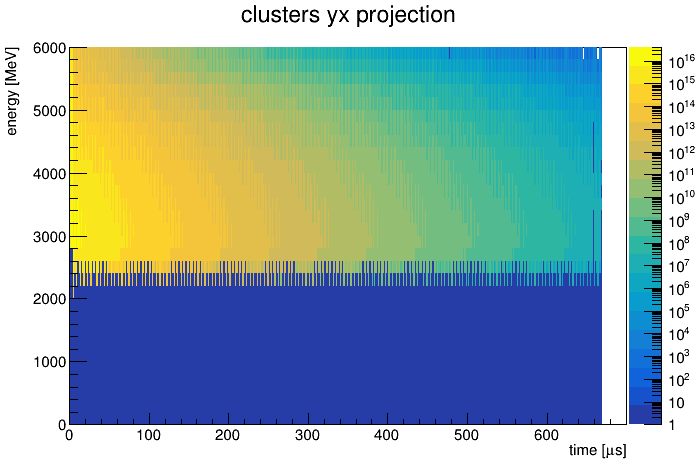

In [16]:
c = r.TCanvas()
doublePileup.Draw("colz")
c.SetLogz()
c.Draw()

In [17]:
c.Print("./pileupCorrection/doublePileup"+fileString+".root")

Info in <TCanvas::SaveAs>: ROOT file ./pileupCorrection/doublePileup_pileupRebinTest.root has been created


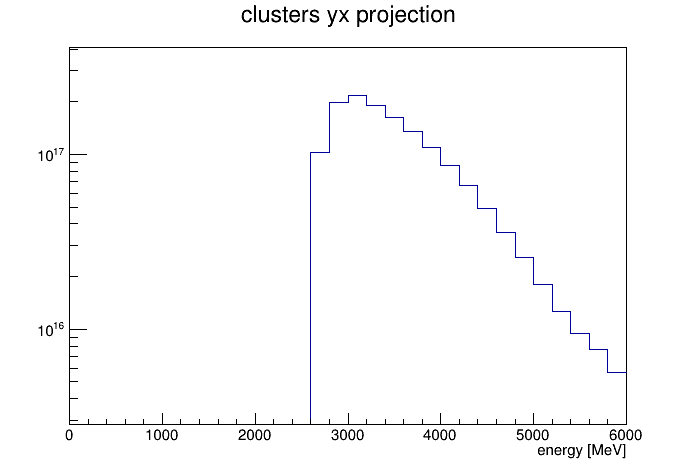

In [18]:
c = r.TCanvas()
doublePileup.ProjectionY().Draw("colz")
c.SetLogy()
c.Draw()

In [19]:
doublePileupInv = doublePileup.Clone("doublePileupInv")

nBinsX = doublePileupInv.GetXaxis().GetNbins()
nBinsY = doublePileupInv.GetYaxis().GetNbins()

for binx in range(1,nBinsX+1):
    #if binx > 100:
    #    break
    #print(binx,"/",nBinsX+1)
    for biny in range(1,nBinsY+1):
        doublePileupInv.SetBinContent(binx,biny,doublePileup.GetBinContent(binx,biny)*(-1))

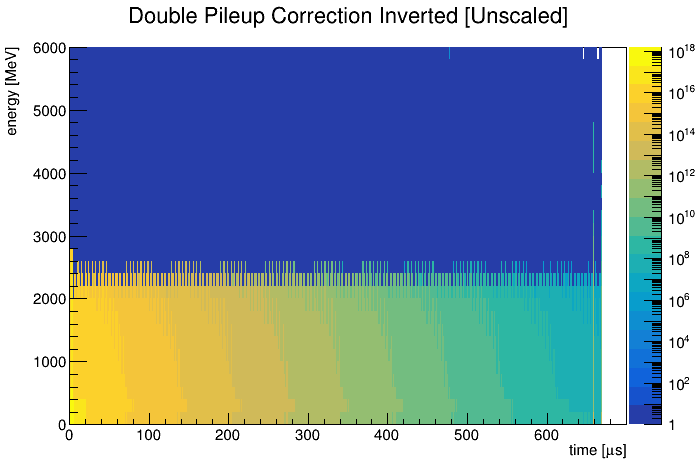

In [20]:
c = r.TCanvas()
doublePileupInv.SetTitle("Double Pileup Correction Inverted [Unscaled]")
doublePileupInv.Draw("colz")

c.SetLogz()
c.Draw()

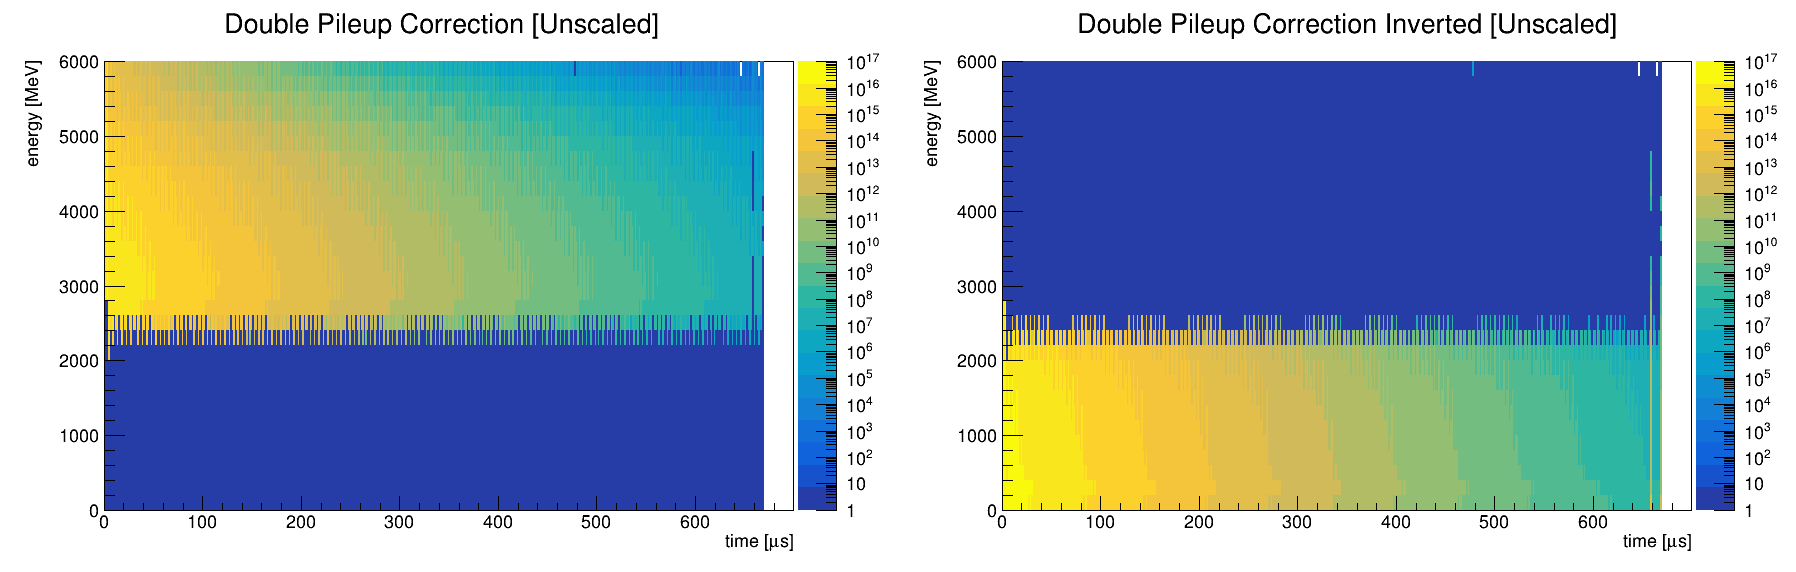

In [21]:
c = r.TCanvas("c","c",1800,600)
c.Divide(2)
c.cd(1)

doublePileup.SetTitle("Double Pileup Correction [Unscaled]")
doublePileup.Draw("colz")
doublePileup.GetZaxis().SetRangeUser(1,10**17)
r.gPad.SetLogz()

c.cd(2)
doublePileupInv.SetTitle("Double Pileup Correction Inverted [Unscaled]")
doublePileupInv.GetZaxis().SetRangeUser(1,10**17)
doublePileupInv.Draw("colz")

r.gPad.SetLogz()
c.Draw()

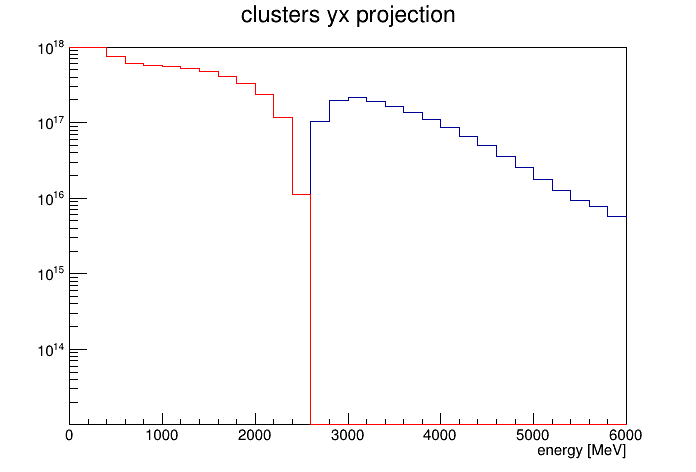

In [22]:
c = r.TCanvas()

doublePileupY = doublePileup.ProjectionY().Clone()
doublePileupY.Draw()
doublePileupY.GetYaxis().SetRangeUser(10**13,10**18)

doublePileupInv.SetLineColor(2)
doublePileupInv.ProjectionY().Draw("same")
c.SetLogy()
c.Draw()

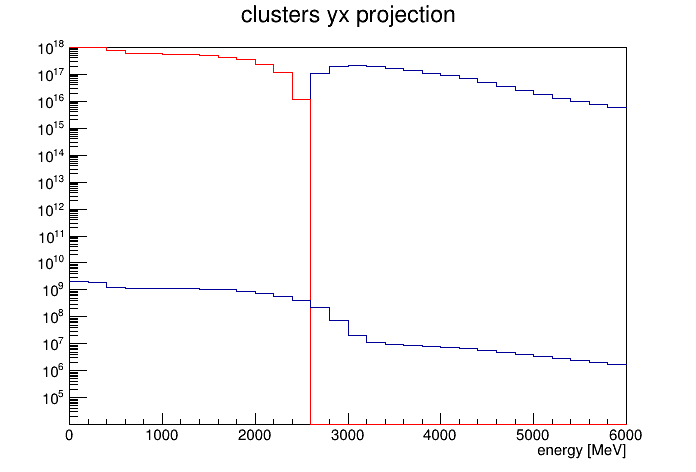

In [23]:
c = r.TCanvas()

doublePileupY = doublePileup.ProjectionY().Clone()
doublePileupY.Draw()
doublePileupY.GetYaxis().SetRangeUser(10**4,10**18)

doublePileupInv.SetLineColor(2)
doublePileupInv.ProjectionY().Draw("same")

Ninitial.ProjectionY().Draw("same")

c.SetLogy()
c.Draw()

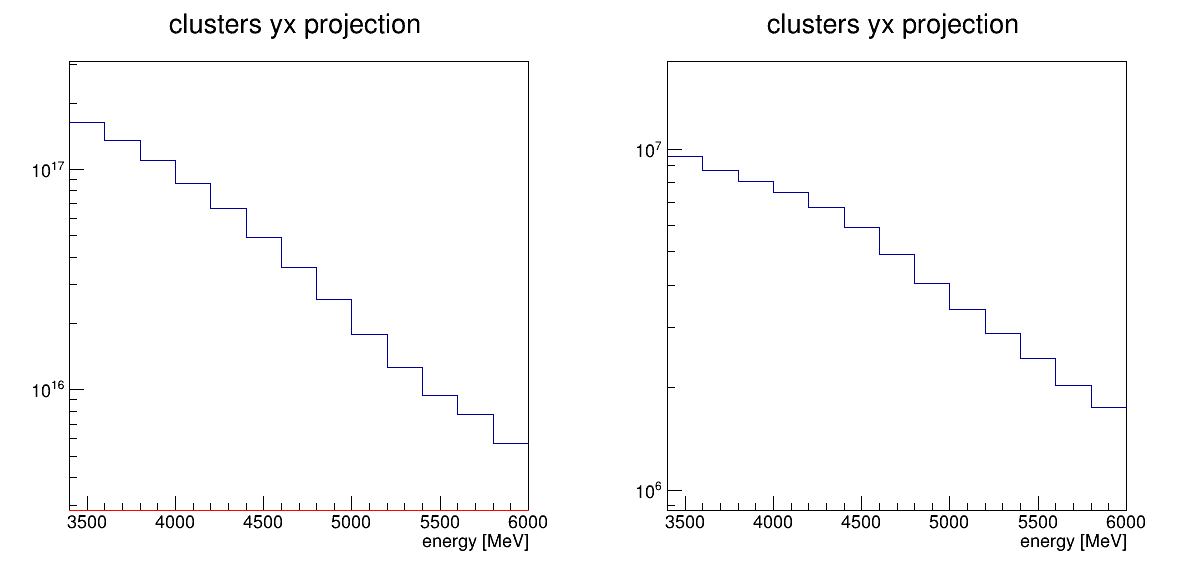

In [24]:
c = r.TCanvas("c","c",1200,600)
c.Divide(2)
c.cd(1)

doublePileupY.Draw()
doublePileupY.GetYaxis().UnZoom()
doublePileupY.GetXaxis().SetRangeUser(3500,6000)

doublePileupInv.SetLineColor(2)
doublePileupInv.ProjectionY().Draw("same")

r.gPad.SetLogy()

c.cd(2)

NinitialY = Ninitial.ProjectionY().Clone()
NinitialY.Draw("same")
NinitialY.GetXaxis().SetRangeUser(3500,6000)


r.gPad.SetLogy()
c.Draw()

---

### Now to fit the double pileup correction to N<sub>initial</sub> using the non-physical tail above 3.5 GeV

This is just a test to understand how to do it, the real pileup correction should fit the double and triple pileup simultainiously

In [25]:
# https://root.cern.ch/root/html/tutorials/fit/fithist.C.html
def fitHist(x, p):
    rawHist = doublePileupY
    scaleFactor = p[0]
    y = rawHist.GetBinContent( rawHist.FindBin(x[0]) ) * scaleFactor
    return y

In [26]:
doublePileupFit = r.TF1("doublePileupFit", fitHist, 3500, 6000, 1)
doublePileupFit.SetParameter(0,1)

In [27]:
NinitialY.Fit("doublePileupFit","REMBS")

 FCN=1.01697e+07 FROM MINOS     STATUS=SUCCESSFUL      2 CALLS          50 TOTAL
                     EDM=3.18744e-12    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           7.95033e-11   1.04712e-14   1.04712e-14  -2.41122e+08


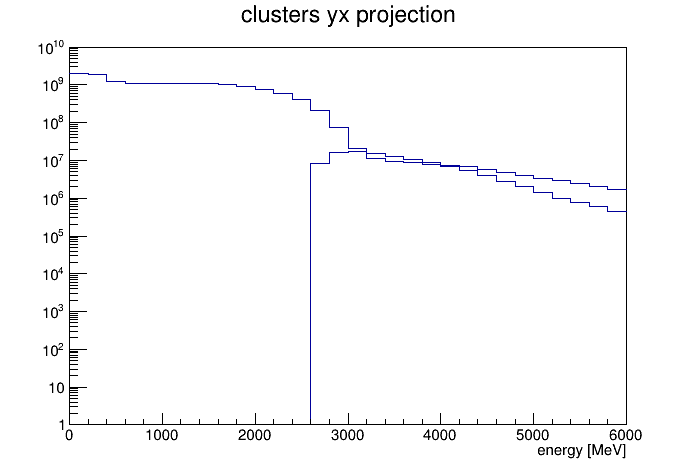

In [28]:
c = r.TCanvas()

doublePileupYScaled = doublePileupY.Clone()
doublePileupYScaled.Scale( doublePileupFit.GetParameter(0) )
doublePileupYScaled.GetXaxis().UnZoom()
doublePileupYScaled.GetYaxis().SetRangeUser(1,10**10)
doublePileupYScaled.Draw()

Ninitial.ProjectionY().Draw("same")

c.SetLogy()
c.Draw()

In [29]:
NdoubleSubtracted = Ninitial.ProjectionY().Clone()
NdoubleSubtracted.Add(doublePileupYScaled,-1)

True

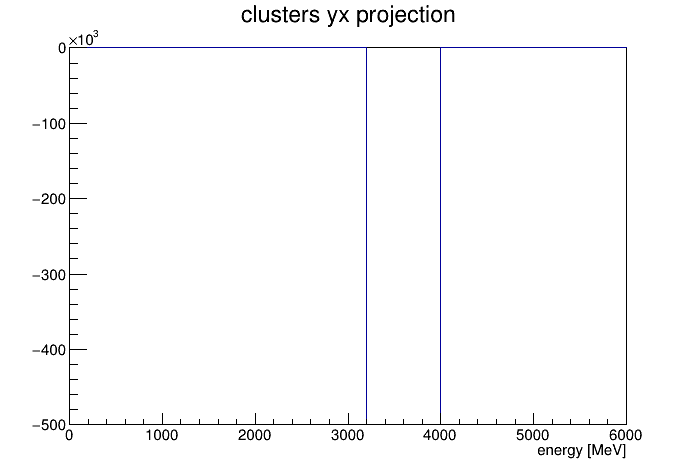

In [30]:
c = r.TCanvas()
NdoubleSubtracted.GetYaxis().SetRangeUser(-500000,1000)
NdoubleSubtracted.Draw("hist")
#c.SetLogy()
c.Draw()

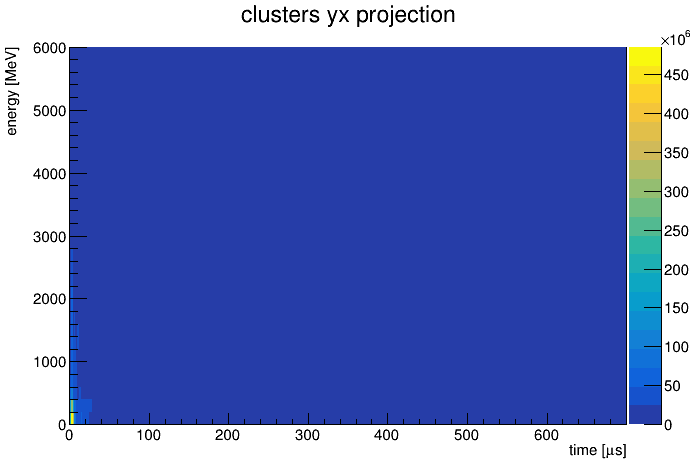

In [31]:
c = r.TCanvas()
NdoubleSubtracted = Ninitial.Clone("NdoubleSubtracted")
doublePileupScaled = doublePileup.Clone("doublePileupScaled")
doublePileupScaled.Scale(doublePileupFit.GetParameter(0))
NdoubleSubtracted.Add( doublePileupScaled, -1 )
NdoubleSubtracted.Draw("colz")
c.Draw()

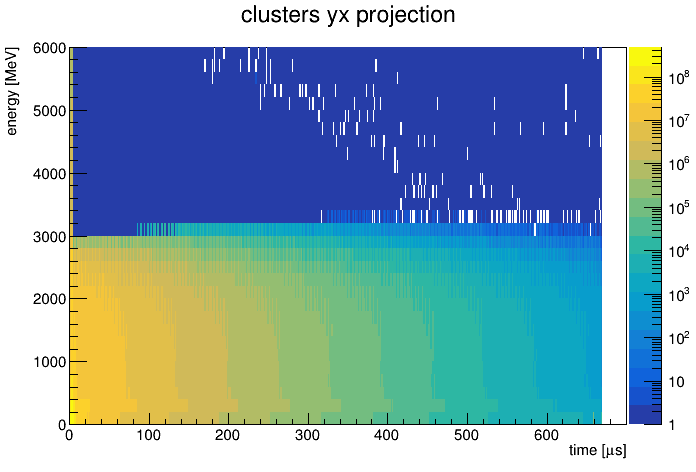

In [32]:
c = r.TCanvas()
NdoubleSubtracted.Draw("colz")
c.SetLogz()
c.Draw()

In [33]:
c.Print("./pileupCorrection/clustersPileupCorrected_DoubleOnly"+fileString+".root")

Info in <TCanvas::SaveAs>: ROOT file ./pileupCorrection/clustersPileupCorrected_DoubleOnly_pileupRebinTest.root has been created


--- 

### And now lets go for gold and build the triple pileup correction (Eq. 6.15)

In [34]:
triplePileup = Ninitial.Clone("triplePileup")
triplePileup.Reset()

In [35]:
def rhoTriplePileup(E, t, rhoDoubleHist, Ninitial, deltaT):
    timeBinN = Ninitial.GetXaxis().FindBin( t )
    energySliceN = Ninitial.ProjectionY("", timeBinN, timeBinN).Clone()
    
    timeBinRho = rhoDoubleHist.GetXaxis().FindBin( t )
    energySliceRho = rhoDoubleHist.ProjectionY("", timeBinRho, timeBinRho).Clone()
    
    int1 = 0
    for bin1 in range( energySliceRho.GetNbinsX() ):
        Ed = energySliceRho.GetBinContent( bin1 )
        if( Ed > E ):
            int1 += 0
        else:
            rho1 = energySliceN.GetBinContent( energySliceN.GetXaxis().FindBin( E - Ed ) )
            rho2 = energySliceRho.GetBinContent( energySliceRho.GetXaxis().FindBin(Ed) )
            int1 += rho1*rho2
            #print(rho1,rho2)
        #print(int1)
    int2 = energySliceN.Integral()
    int3 = (int2)**2
    
    rhoDoubleEt = rhoDoubleHist.GetBinContent( rhoDoubleHist.GetXaxis().FindBin(t), rhoDoubleHist.GetYaxis().FindBin(E) )
    rhoEt = Ninitial.GetBinContent( Ninitial.GetXaxis().FindBin(t), Ninitial.GetYaxis().FindBin(E) )
    
    #print("***************************************")
    #print(int1,int2,int3)
    #print(rhoDoubleEt, rhoEt)
    #print(((deltaT)**2) * ( int1 ) )
    #print( int1 , - 3*rhoDoubleEt*int2 , 3*rhoEt*int3 )
    
    return ((deltaT)**2) * ( int1 - 3*rhoDoubleEt*int2 + 3*rhoEt*int3 )

In [36]:
for i in range(1,100,10):
    print(i)
    rhoTriplePileup(5000, i, rhoDoubleHist, Ninitial, deltaT)

1
11
21
31
41
51
61
71
81
91


In [37]:
nBinsX = triplePileup.GetXaxis().GetNbins()
nBinsY = triplePileup.GetYaxis().GetNbins()

for binx in range(1,nBinsX+1):
    #if binx > 10:
    #    break
    print(binx,"/",nBinsX+1)
    for biny in range(1,nBinsY+1):
        Ei = triplePileup.GetYaxis().GetBinCenter(biny)
        ti = triplePileup.GetXaxis().GetBinCenter(binx)
        rhoi = rhoTriplePileup(Ei, ti, rhoDoubleHist, Ninitial, deltaT)
        #print(rhoi)
        triplePileup.SetBinContent(binx,biny,rhoi)

1 / 470
2 / 470
3 / 470
4 / 470
5 / 470
6 / 470
7 / 470
8 / 470
9 / 470
10 / 470
11 / 470
12 / 470
13 / 470
14 / 470
15 / 470
16 / 470
17 / 470
18 / 470
19 / 470
20 / 470
21 / 470
22 / 470
23 / 470
24 / 470
25 / 470
26 / 470
27 / 470
28 / 470
29 / 470
30 / 470
31 / 470
32 / 470
33 / 470
34 / 470
35 / 470
36 / 470
37 / 470
38 / 470
39 / 470
40 / 470
41 / 470
42 / 470
43 / 470
44 / 470
45 / 470
46 / 470
47 / 470
48 / 470
49 / 470
50 / 470
51 / 470
52 / 470
53 / 470
54 / 470
55 / 470
56 / 470
57 / 470
58 / 470
59 / 470
60 / 470
61 / 470
62 / 470
63 / 470
64 / 470
65 / 470
66 / 470
67 / 470
68 / 470
69 / 470
70 / 470
71 / 470
72 / 470
73 / 470
74 / 470
75 / 470
76 / 470
77 / 470
78 / 470
79 / 470
80 / 470
81 / 470
82 / 470
83 / 470
84 / 470
85 / 470
86 / 470
87 / 470
88 / 470
89 / 470
90 / 470
91 / 470
92 / 470
93 / 470
94 / 470
95 / 470
96 / 470
97 / 470
98 / 470
99 / 470
100 / 470
101 / 470
102 / 470
103 / 470
104 / 470
105 / 470
106 / 470
107 / 470
108 / 470
109 / 470
110 / 470
111 / 47

In [38]:
c.Print("./pileupCorrection/triplePileup_Unscaled"+fileString+".root")

Info in <TCanvas::SaveAs>: ROOT file ./pileupCorrection/triplePileup_Unscaled_pileupRebinTest.root has been created


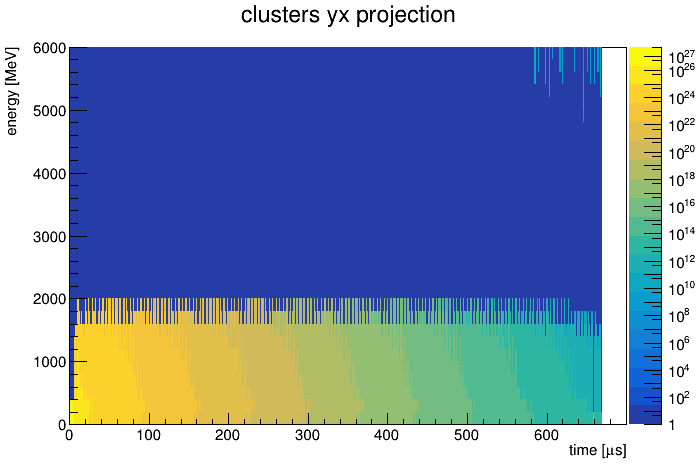

In [39]:
c = r.TCanvas()
triplePileup.Draw("colz")
c.SetLogz()
c.Draw()

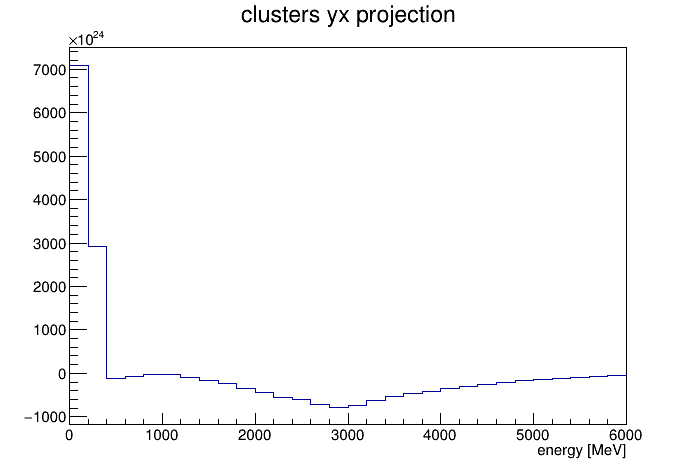

In [40]:
c = r.TCanvas()
triplePileupY = triplePileup.ProjectionY().Clone()
triplePileupY.Draw()
c.Draw()

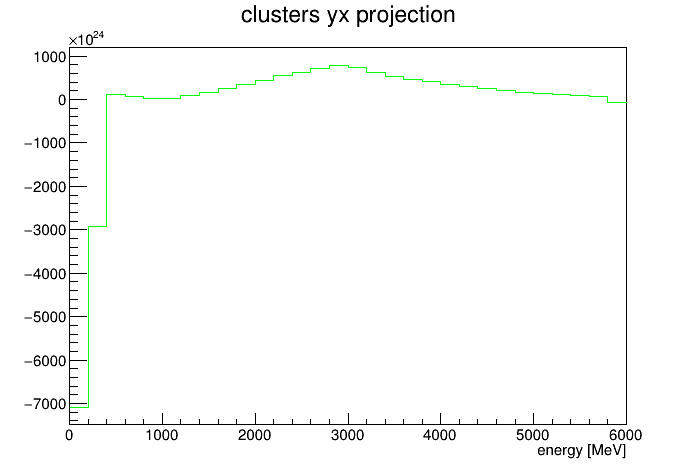

In [41]:
c = r.TCanvas()
triplePileupYInv = triplePileupY.Clone()
for i in range(triplePileupY.GetNbinsX()):
    triplePileupYInv.SetBinContent(i, (-1)*triplePileupY.GetBinContent(i))
triplePileupYInv.SetLineColor(3)
triplePileupYInv.Draw()
c.Draw()

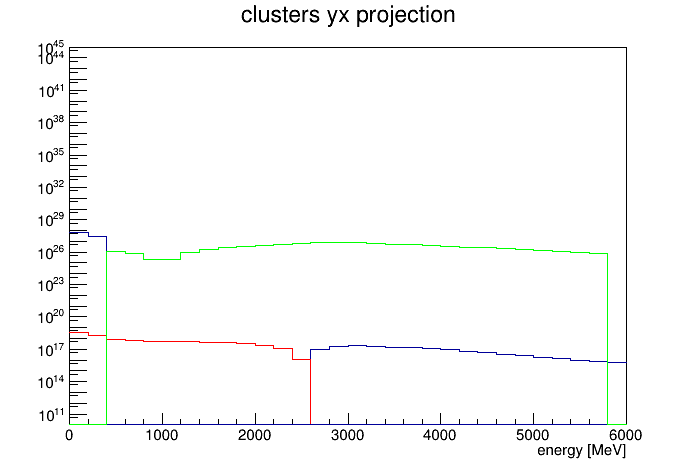

In [42]:
c = r.TCanvas()
doublePileupY.Draw()
doublePileupY.GetXaxis().SetRangeUser(0,6000)
doublePileupY.GetYaxis().SetRangeUser(10**10,10**45)
doublePileupInv.ProjectionY().Draw("same")
triplePileupY.Draw("same")
triplePileupYInv.Draw("SAME")
c.SetLogy()
c.Draw()

---

### And now fit to a linear combo of the double and triple pileup

In [43]:
# https://root.cern.ch/root/html/tutorials/fit/fithist.C.html
def fitHistTrip(x, p):
    rawHistDouble = doublePileupY
    rawHistTriple = triplePileupY
    scaleFactorDouble = p[0]
    scaleFactorTriple = p[1]
    y = ( rawHistDouble.GetBinContent( rawHistDouble.FindBin(x[0]) ) * scaleFactorDouble 
         + rawHistTriple.GetBinContent( rawHistTriple.FindBin(x[0]) ) * scaleFactorTriple )
    return y

In [44]:
triplePileupFit = r.TF1("triplePileupFit", fitHistTrip, 3500, 6000, 2)
triplePileupFit.SetParameters(0.00000000000000000001,-0.00000000001)

In [45]:
for i in range(2):
    NinitialY.Fit("triplePileupFit","REMBS")

 FCN=1.35057e+06 FROM MIGRAD    STATUS=FAILED        107 CALLS         108 TOTAL
                     EDM=2.5775e+06    STRATEGY= 1      ERR MATRIX APPROXIMATE
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0          -1.51500e-14   4.10163e-14   5.94193e-15   5.53550e+16
   2  p1          -2.10468e-20   1.01105e-23   4.88281e-19   4.49614e+14
 FCN=61824.8 FROM MINOS     STATUS=SUCCESSFUL      8 CALLS          68 TOTAL
                     EDM=9.34784e-12    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0          -4.65782e-11   4.10163e-14  -0.00000e+00   4.06608e+08
   2  p1          -3.21443e-20   1.01105e-23   1.01105e-23  -4.64350e+13


Warning in <Fit>: Abnormal termination of minimization.


In [46]:
doublePileupScaled = doublePileup.Clone("doublePileupScaled")
doublePileupScaled.Scale(triplePileupFit.GetParameter(0))

triplePileupScaled = triplePileup.Clone("triplePileupScaled")
triplePileupScaled.Scale(triplePileupFit.GetParameter(1))

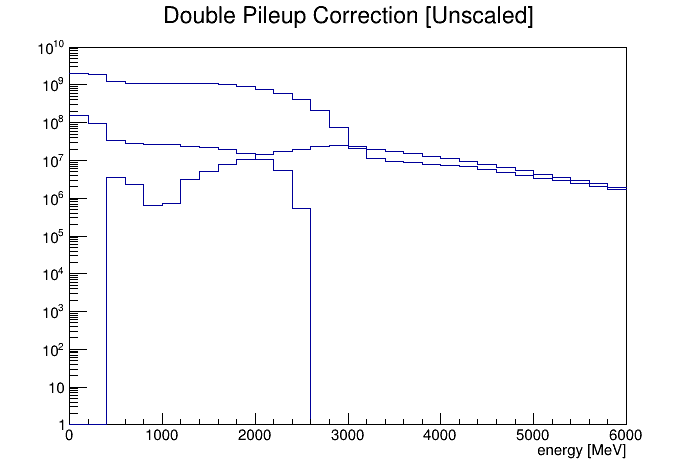

In [47]:
c = r.TCanvas()

doublePileupScaledY = doublePileupScaled.ProjectionY().Clone()
doublePileupScaledY.Draw("hist")
doublePileupScaledY.GetXaxis().SetRangeUser(0,6000)
doublePileupScaledY.GetYaxis().SetRangeUser(1,10**10)

triplePileupScaled.ProjectionY().Draw("hist same")

Ninitial.ProjectionY().Draw("SAME")

c.SetLogy()
c.Draw()

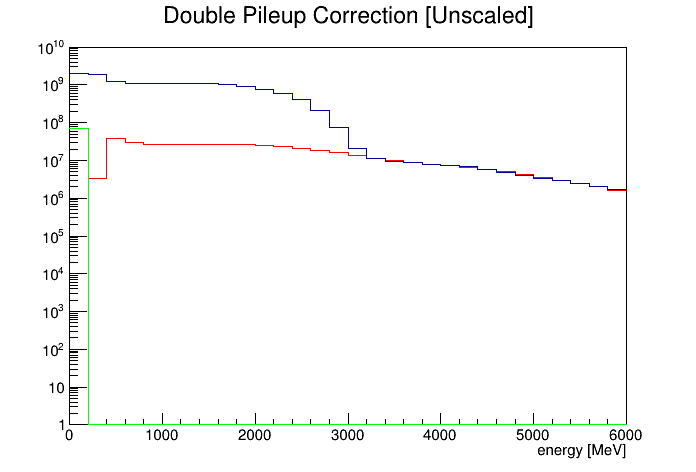

In [48]:
c = r.TCanvas()

totalPileupScaled = doublePileupScaledY.Clone()
totalPileupScaled.Add(triplePileupScaled.ProjectionY(),1)
totalPileupScaled.SetLineColor(2)
totalPileupScaled.Draw("hist")

totalPileupScaled.GetXaxis().SetRangeUser(0,6000)
totalPileupScaled.GetYaxis().SetRangeUser(10**0,10**10)

totalPileupScaledInv = totalPileupScaled.Clone()
for i in range(totalPileupScaled.GetNbinsX()+1):
    totalPileupScaledInv.SetBinContent(i, -1*totalPileupScaled.GetBinContent(i))
totalPileupScaledInv.SetLineColor(3)
totalPileupScaledInv.Draw("hist SAME")

Ninitial.ProjectionY().Draw("SAME")

c.SetLogy()
c.Draw()

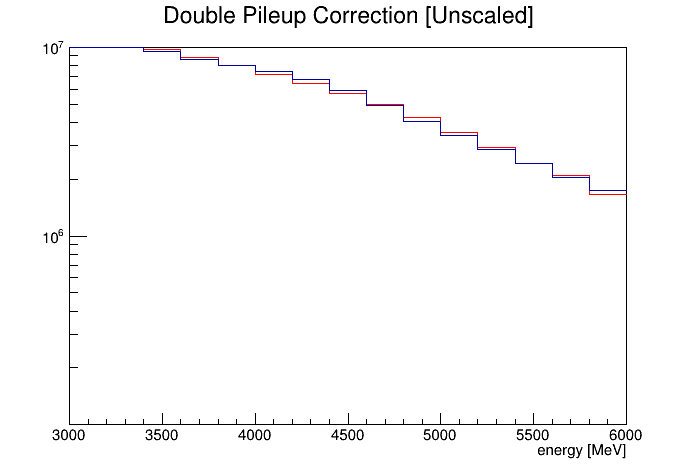

In [49]:
c = r.TCanvas()

totalPileupScaled.Draw("hist")

totalPileupScaled.GetXaxis().SetRangeUser(3000,6000)
totalPileupScaled.GetYaxis().SetRangeUser(10**5,10**7)

Ninitial.ProjectionY().Draw("SAME")

c.SetLogy()
c.Draw()

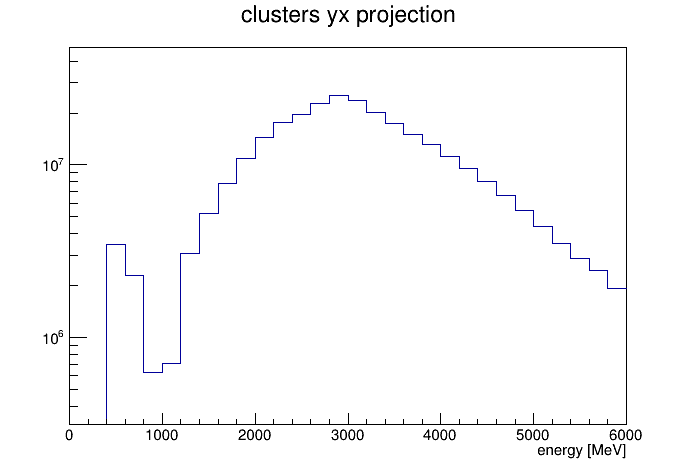

In [50]:
c = r.TCanvas()

triplePileupScaled.ProjectionY().Draw("hist ")

c.SetLogy()
c.Draw()

In [51]:
NtriplePileup = Ninitial.Clone("NtriplePileup")
NtriplePileup.Add(doublePileupScaled, -1)
NtriplePileup.Add(triplePileupScaled, -1)

True

Info in <TCanvas::SaveAs>: ROOT file ./pileupCorrection/NtriplePileupCorrected_pileupRebinTest.root has been created


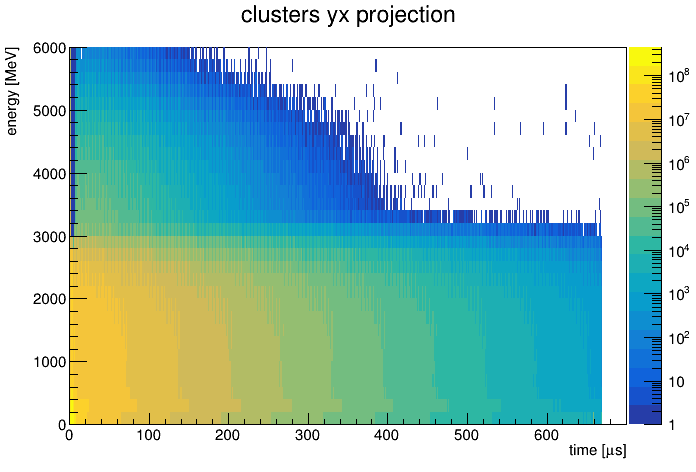

In [52]:
c = r.TCanvas()
NtriplePileup.Draw("colz")
c.SetLogz()
c.Draw()
c.Print("./pileupCorrection/NtriplePileupCorrected"+fileString+".root")

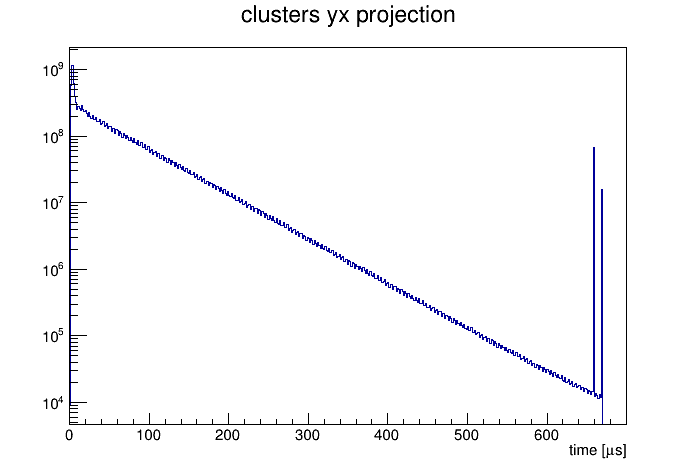

In [53]:
c = r.TCanvas()
NtriplePileup.ProjectionX().Draw("hist")
c.SetLogy()
c.Draw()

In [54]:
NtriplePileupInv = NtriplePileup.ProjectionY().Clone()
for i in range(NtriplePileupInv.GetNbinsX()):
    NtriplePileupInv.SetBinContent(i, NtriplePileupY.GetBinContent(i)*(-1))
NtriplePileupInv.SetLineColor(2)

NameError: name 'NtriplePileupY' is not defined

In [ ]:
c = r.TCanvas()
NtriplePileupY = NtriplePileup.ProjectionY().Clone()
NtriplePileupY.SetTitle("Energy Spectrum After Pileup Correction")
NtriplePileupY.Draw("hist")
NtriplePileupY.GetXaxis().SetRangeUser(0,6000)
NtriplePileupY.GetYaxis().SetRangeUser(1,10**9)
NtriplePileupInv.Draw("hist same")
c.SetLogy()
c.Draw()

In [ ]:
c = r.TCanvas()
binLow = NtriplePileup.GetYaxis().FindBin(1700)
binHigh = NtriplePileup.GetYaxis().FindBin(3300)
NtriplePileup.ProjectionX("",binLow,binHigh).Draw("hist")
c.SetLogy()
c.Draw()

In [ ]:
c = r.TCanvas()
correctedWiggle = NtriplePileup.ProjectionX("",
                                           NtriplePileup.GetYaxis().FindBin(3500),
                                           NtriplePileup.GetYaxis().FindBin(6000)).Clone("correctedWiggle")
uncorrectedWiggle = Ninitial.ProjectionX("",
                                           Ninitial.GetYaxis().FindBin(3500),
                                           Ninitial.GetYaxis().FindBin(6000)).Clone("uncorrectedWiggle")
correctedWiggle.SetLineColor(2)
uncorrectedWiggle.SetTitle("Hits [3.5 GeV < E < 6.0 GeV] Before and After Pileup Correction")

uncorrectedWiggle.GetYaxis().SetRangeUser(-10000,30000)
uncorrectedWiggle.GetXaxis().SetRangeUser(30,180)
uncorrectedWiggle.Draw()

correctedWiggle.Draw("SAME")

leg = r.TLegend(0.6,0.8,0.9,0.9)
leg.AddEntry(uncorrectedWiggle,"Uncorrected Hits")
leg.AddEntry(correctedWiggle,"Corrected Hits")
leg.Draw("SAME")

c.SetGrid()

c.Draw()